In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as U
import torch.nn.functional as F
from torchvision.datasets import MNIST

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd
import numpy as np

def image_transform(img):
    return T.ToTensor()(img)
    
train_ds = MNIST(root=".", download=True, train=True, transform=image_transform)
test_ds = MNIST(root=".", download=True, train=False, transform=image_transform)


train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f' using device: {device}')

 using device: cuda


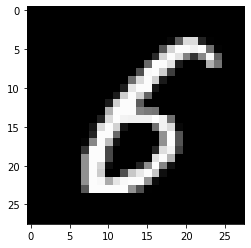

In [3]:
sample_imgs, sample_labels = next(iter(train_dataloader))

plt.imshow(sample_imgs[0].squeeze(dim=0), cmap="gray")

In [99]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 3, 3),
            nn.Tanh(),
            nn.Conv2d(3, 6, 3),
            nn.Tanh(),
            nn.Conv2d(6, 10, 3),
            nn.AdaptiveAvgPool2d((1, 1))            
        )
        # self.final_layer = nn.Linear(1210, 10)

    def forward(self, x):
        conv_output = self.conv_stack(x)
        # print(f'convolutional output: {conv_output.shape} {conv_output.flatten(start_dim=1).shape}') 
        # maxpool_output = F.avg_pool2d(conv_output, conv_output.shape[-1], stride=1)


        # maxpool_output = nn.MaxPool2d(conv_output.shape[-1], stride=1)(conv_output)
        return conv_output.squeeze()
        # return self.final_layer(conv_output.flatten(start_dim=1))


In [100]:
test_net = FCN()
print(test_net)
test_net(sample_imgs).argmax(dim=1)

FCN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
    (5): AdaptiveAvgPool2d(output_size=(1, 1))
  )
)


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [6]:
from tqdm.notebook import tqdm

def train(model, dataloader, loss_func, optimizer_func, verbose=True):
    model.train()
    loss_arr = []

    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_func(pred, y)
        optimizer_func.zero_grad()
        loss.backward()
        optimizer_func.step()

        loss_arr.append(loss.item())
        
        if verbose and batch%100 == 0: print(f'batch: {batch} loss: {loss.item()} [{batch*len(X)} / {len(dataloader.dataset)}]')
    return loss_arr

In [7]:
@torch.no_grad()
def test(model, dataloader):
    correct = 0
    total = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        correct += sum(pred.argmax(dim=1) == y)
    return [correct, total]

In [14]:

def test_learning_rates(Network, dataloader, learning_rates):
    losses = []
    for lr in learning_rates:
        loss_func = nn.CrossEntropyLoss()
        main_net = Network().to(device)
        optimizer_func = torch.optim.Adam(main_net.parameters(), lr=lr)
        
        loss_arr = train(main_net, dataloader, loss_func, optimizer_func, verbose=False)

        losses.append(loss_arr)
    return losses


In [101]:

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.9]
total_losses = test_learning_rates(FCN, train_dataloader, learning_rates)

rows,cols, idx = 3, 3, 0
subs = make_subplots(rows=rows, cols=cols, subplot_titles=learning_rates)

for row in range(rows):
    for col in range(cols):
        if(row == 2 and col == 1): break;
        subs.add_trace(go.Scatter(y=total_losses[idx]), row=row+1, col=col+1)
        idx+=1

subs.show()

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [102]:
myNet = FCN().to(device)

In [110]:
epochs  = 15
loss_fn = nn.CrossEntropyLoss()
total_losses = []
avg_losses = []
lr = 0.9

for i in range(epochs):
    print("Epoch: ", i+1)
    optimizer = torch.optim.SGD(params=myNet.parameters(), lr=lr)
    loss_arr = train(myNet, train_dataloader, loss_fn, optimizer, verbose=False)
    avg = sum(loss_arr)/len(loss_arr)
    avg_losses.append(avg)
    print("Average Loss: ", avg)
    total_losses.append(loss_arr)

Epoch:  1


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.37757774064345145
Epoch:  2


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.377153035356546
Epoch:  3


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.3727595183863314
Epoch:  4


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.3726255510057976
Epoch:  5


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.36909017657865084
Epoch:  6


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.3674839969827676
Epoch:  7


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.3671623835288512
Epoch:  8


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.36535938185796557
Epoch:  9


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.3643056582858059
Epoch:  10


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.36198636673406753
Epoch:  11


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.36278659062408436
Epoch:  12


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.3653834507758938
Epoch:  13


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.36114943551737616
Epoch:  14


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.36114889262581684
Epoch:  15


  0%|          | 0/938 [00:00<?, ?it/s]

Average Loss:  0.3578097319869853


In [111]:
px.line(avg_losses)

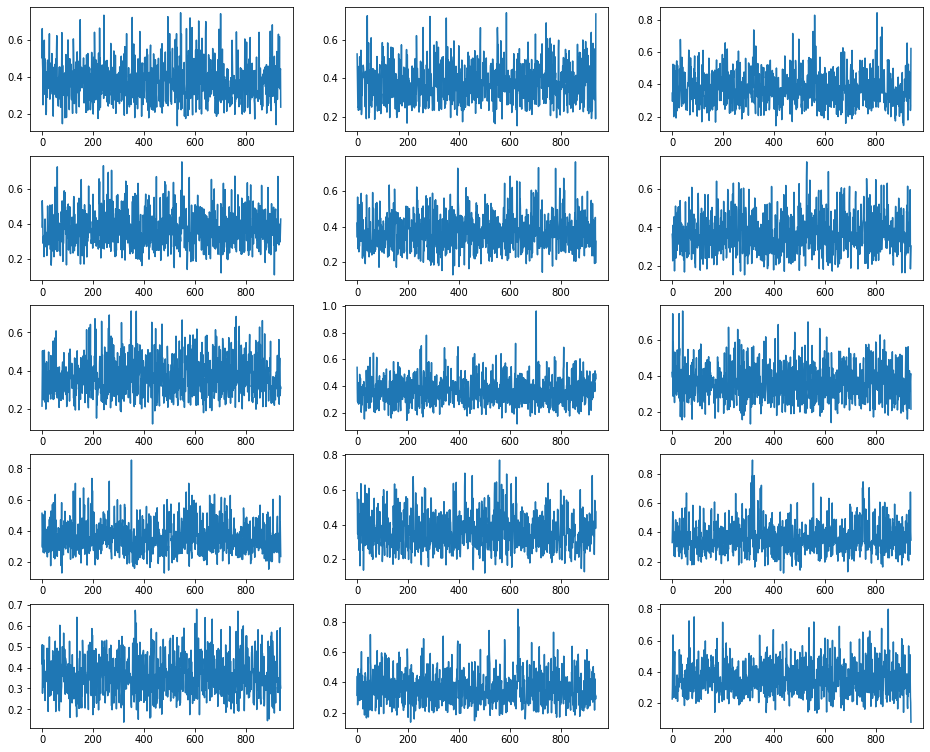

In [115]:
cols = 3
rows = epochs//3 + 1
plt.figure(figsize=(16, 16))
for idx in range(epochs):
    plt.subplot(rows, cols, idx+1)
    plt.plot(total_losses[idx])

In [114]:
[correct, total] = test(myNet, test_dataloader)
print("Accuracy: ", correct/total*100)

Accuracy:  tensor(89.3700, device='cuda:0')
